In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Normalize images to [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert the color images to grayscale for input (1 channel)
x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
x_test_gray = tf.image.rgb_to_grayscale(x_test).numpy()

print("Training set shapes: color:", x_train.shape, "grayscale:", x_train_gray.shape)
print("Test set shapes: color:", x_test.shape, "grayscale:", x_test_gray.shape)

Training set shapes: color: (50000, 32, 32, 3) grayscale: (50000, 32, 32, 1)
Test set shapes: color: (10000, 32, 32, 3) grayscale: (10000, 32, 32, 1)


In [32]:
# Load VGG19 model (Pretrained on ImageNet) as feature extractor
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg.trainable = False  # Freeze VGG19 to keep training time low

# Extract first few layers for grayscale feature extraction
encoder = models.Model(vgg.input, vgg.get_layer("block2_conv2").output)
encoder.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,160 (1016.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 260,160 (1016.25 KB)

In [45]:
# Build the decoder network
decoder_input = layers.Input(shape=encoder.output.shape[1:])  # Match encoder output

x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(decoder_input)
#x = layers.UpSampling2D((2,2))(x)  # Upsample to 16x16
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)  # Upsample to 32x32
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)  # Output (32x32x3)

decoder = models.Model(decoder_input, x)
decoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 665,731 (2.54 MB)

 Trainable params: 665,731 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [47]:
# Full autoencoder (grayscale -> VGG features -> color output)
input_img = layers.Input(shape=(32, 32, 1))
gray_to_rgb = layers.Conv2D(3, (3, 3), padding='same')(input_img)  # Convert grayscale to 3 channels
encoded_features = encoder(gray_to_rgb)  # Extract features using VGG19
decoded_output = decoder(encoded_features)  # Decode to color image

autoencoder = models.Model(input_img, decoded_output)
autoencoder.compile(optimizer='adam', loss=ssim_loss)
autoencoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 16, 16, 128)         │         260,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, 32, 32, 3)           │         665,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 925,921 (3.53 MB)

 Trainable params: 665,761 (2.54 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [48]:
history = autoencoder.fit(x_train_gray, x_train,
                          epochs=25,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_gray, x_test))

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - loss: 0.2150 - val_loss: 0.1028
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 0.0968 - val_loss: 0.0897
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0901 - val_loss: 0.0879
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 0.0862 - val_loss: 0.0838
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0836 - val_loss: 0.0836
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0825 - val_loss: 0.0802
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.0807 - val_loss: 0.0793
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0802 - val_loss: 0.0785
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0785 - val_loss: 0.0785
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0785 - val_loss: 0.0801
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0781 - val_loss: 0.0767
Epoch 12/25
391/391 ━━━━━━━━━━

In [49]:
autoencoder.save_weights('/content/drive/MyDrive/autoencoder_colorization.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


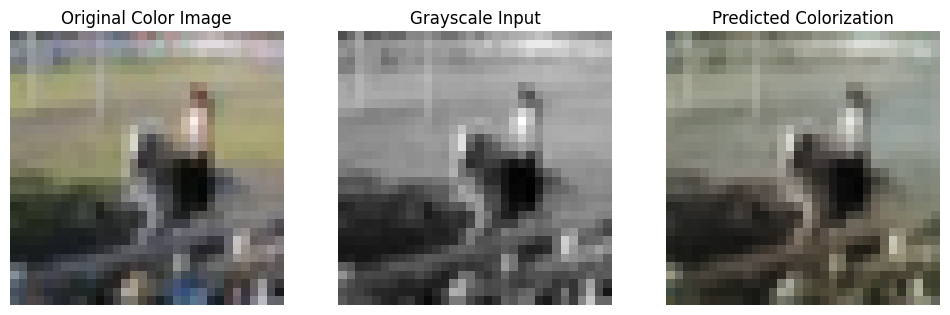

In [57]:
# Test the model on some test images
# Pick a random test image
idx = np.random.randint(0, x_test_gray.shape[0])
gray_sample = x_test_gray[idx:idx+1]
color_sample = x_test[idx]

# Predict the colorization for the grayscale image
predicted_color = autoencoder.predict(gray_sample)[0]

# Plot the original color image, grayscale image, and the predicted color image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Color Image")
plt.imshow(color_sample)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grayscale Input")
# squeeze the last dimension since it's a single channel
plt.imshow(gray_sample.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Colorization")
plt.imshow(predicted_color)
plt.axis('off')

plt.show()